In [1]:
import csv
import pandas as pd

In [2]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) 

In [4]:
# Cassandra metadata
dev_cassandra_host= '10.2.231.96'
dev_username= 'loaddata'
dev_password= 'DecujRiQuigByaibdednofVerr6Odij2'
parcours_keyspace = 'parcours'
prospect_table = 'referentiel_prospects'
valo_retro_one_month_table = 'retro_valo_client_un_mois'
valo_retro_one_month_table_test = 'retro_valo_client_un_mois_test'
top_prospect_one_month_table = 'top_prospect_encours_un_mois'
top_prospect_six_months_table = 'top_prospect_encours_six_mois'
score_prospect_encours_table = 'score_prospect_encours'

In [5]:
# Elasticsearch hostname
dev_es_host= 'dtl-esmaster01-d01'

In [6]:
# Elasticsearch port
dev_es_port= 9200

In [7]:
# Path to pickle one month 'encours' and csv matching files
#path_to_one_month_pickle = "./MODEL/ENCOURS_1MOIS/"
path_to_one_month_pickle = "/home/projet-encours/dtl-encours/MODEL/ENCOURS_1MOIS/"


In [8]:
#path_to_six_months_pickle = "./MODEL/ENCOURS_6MOIS/"
path_to_six_months_pickle = "/home/projet-encours/dtl-encours/MODEL/ENCOURS_6MOIS/"


In [9]:
# Path to module's parent dir in dev env
dev_sys_path = '/home/dtl-pnb/'


In [10]:
# One month model target name
one_month_target_name = 'ENCOURS_1MOIS'
six_months_target_name = 'ENCOURS_6MOIS'


In [11]:
auth_provider = PlainTextAuthProvider(username=dev_username, password=dev_password)


In [12]:
cluster = Cluster(contact_points = [dev_cassandra_host], protocol_version=3, auth_provider=auth_provider)



In [13]:
session = cluster.connect('parcours')

In [14]:
class CassandraClient:

    def __init__(self, keyspace):
        self.auth_provider = None
        self.cluster = None
        self.session = None
        self.keyspace = keyspace
        self.create_session()
        self.prepare_statements()

    def create_session(self):
        self.auth_provider = PlainTextAuthProvider(username=dev_username, password=dev_password)
        self.cluster = Cluster(contact_points = [dev_cassandra_host], protocol_version=3, auth_provider=self.auth_provider)
        self.session = self.cluster.connect(parcours_keyspace)

    def get_session(self):
        return self.session

    def prepare_statements(self):
        self.statement_get_prospects = self.session.prepare('select * from ' + prospect_table + ' WHERE csp>-1 ALLOW FILTERING')
        #self.statement_get_valo_retro_one_month = self.session.prepare('select * from ' + config.valo_retro_one_month_table + ' where encours>-1 ALLOW FILTERING')
        self.statement_get_valo_retro_one_month = self.session.prepare('select * from retro_valo_client_un__mois where encours>-1 ALLOW FILTERING')
        self.statement_get_valo_retro_one_month_test = self.session.prepare('select * from ' + valo_retro_one_month_table_test)
        #+ ' WHERE id_dim_personne=\'6737208161\' ALLOW FILTERING'
        self.statement_truncate_score_prospect = self.session.prepare('TRUNCATE ' + score_prospect_encours_table)
        self.statement_insert_six_months_score_encours = self.session.prepare(self.get_statement_insert_score_encours('six_months'))
        self.statement_insert_one_months_score_encours = self.session.prepare(self.get_statement_insert_score_encours('one_month'))

    def get_statement_insert_score_encours(self, target):
        return {
            'one_month' : 'INSERT INTO ' + score_prospect_encours_table + ' (contactid, score_prospect_encours_six_mois, timestamp, id_dim_temps, cible_encours_six_mois) VALUES (?,?,?,?,?)',
            'six_months': 'INSERT INTO ' + score_prospect_encours_table + ' (contactid, score_prospect_encours_un_mois, timestamp, id_dim_temps, cible_encours_un_mois) VALUES (?,?,?,?,?)',
        }.get(target, 'Unknown target specified')

    def insert_one_month_score_encours(self, data_frame):
        values = data_frame[["contactid","ENCOURS_1MOIS_proba","timestamp","id_dim_temps","predicted_target_ENCOURS_1MOIS"]].values
        for i in range(data_frame.iloc[0:data_frame["ENCOURS_1MOIS_proba"].count()].shape[0]):
            bound_stmt = self.statement_insert_one_months_score_encours.bind([values[i,0],values[i,1],values[i,2],values[i,3],values[i,4]])
            self.session.execute(bound_stmt)

    def insert_six_month_score_encours(self, data_frame):
        values = data_frame[["contactid","ENCOURS_6MOIS_proba","timestamp","id_dim_temps","predicted_target_ENCOURS_6MOIS"]].values
        for i in range(data_frame.iloc[0:data_frame["ENCOURS_6MOIS_proba"].count()].shape[0]):
            bound_stmt = self.statement_insert_six_months_score_encours.bind([values[i,0],values[i,1],values[i,2],values[i,3],values[i,4]])
            self.session.execute(bound_stmt)

    def get_df_from_query(self,prepared_query):
        resultset = self.session.execute(prepared_query)
        resultset[0]
        df = pd.DataFrame()
        for num_col in range(len(resultset.column_names)):
            result_col = []
            for row in resultset:
                result_col.append(row[num_col])
            df[resultset.column_names[num_col]] = result_col
        return df

    def get_df_from_query2(self,prepared_query):
        resultset = self.session.execute(prepared_query)
        resultset[0]
        df = pd.DataFrame()
        for r in resultset:
            df = df.append(r)
        return df


In [15]:
pd.options.display.float_format = '{:.0f}'.format
dfp = pd.read_csv('vp.csv', sep=',', encoding='UTF-8')
dfp

,id_parain
0,2754681582
1,224108008
2,nan
3,nan
4,1697958997
5,nan
6,814632101
7,279756350
8,nan
9,640596171


In [16]:
df_encours = pd.read_csv("df_encours.csv", delimiter=",")

In [17]:
df_encours

,Unnamed: 0,id_dim_personne,encours,cible
0,0,331850710,310,0
1,1,1004250808,12780,1
2,2,1529146396,5000,1
3,3,1660202716,300,0
4,4,1715100837,1068,0
5,5,1725735525,2730,1
6,6,1748840201,360,0
7,7,1766903833,285,0
8,8,1887361163,297,0
9,9,1890939986,260,0


In [18]:
# concat the original data with the id_dim_personne godfather
enriched_df = pd.concat([df_encours, dfp], axis=1, ignore_index=True)
enriched_df.columns = ['Unnamed: 0','id_dim_personne','encours','cible','id_parain']
enriched_df.head(5)

enriched_df['id_parain'] = pd.to_numeric(enriched_df['id_parain'])
enriched_df

,Unnamed: 0,id_dim_personne,encours,cible,id_parain
0,0,331850710,310,0,2754681582
1,1,1004250808,12780,1,224108008
2,2,1529146396,5000,1,nan
3,3,1660202716,300,0,nan
4,4,1715100837,1068,0,1697958997
5,5,1725735525,2730,1,nan
6,6,1748840201,360,0,814632101
7,7,1766903833,285,0,279756350
8,8,1887361163,297,0,nan
9,9,1890939986,260,0,640596171


In [19]:
cc = CassandraClient(parcours_keyspace)
prospects_ref = cc.get_df_from_query(cc.statement_get_prospects)
prospects_ref['contactid'] = pd.to_numeric(prospects_ref['contactid'])
df = pd.merge(prospects_ref,enriched_df, right_on='id_dim_personne', left_on='contactid')

In [20]:
df

,contactid,annee_mois,campagne,campaign,civilite,code_postal,code_postal_naissance,country_connexion_name,csp,date_naissance,debit_cb,firstnamesponsor,flag_banque_principale,flag_epargne,id_dim_temps,mail,mailing_accord,namesponsor,nature_cb,patrimoine,pays,pays_naissance,regime_matrimonial,revenus_annuels,service,timestamp,Unnamed: 0,id_dim_personne,encours,cible,id_parain
0,6546762003,nan,-1,Source URL non trouvée,,,59430,France,15,,,,1,0,20160920,,,,,-1,,FRA,2,2,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-09-21T01:28:13.601+0200,6842,6546762003,5,0,nan
1,6742433330,nan,456,REC_Liens textes autopromotion 456,0,31130,38000,France,2,11/04/1969,0,None,0,0,20161031,stephan.chevalier@yahoo.fr,0,None,1,2,FRA,FRA,4,2,SFOL_AJOUTER_CB,2016-10-31T18:16:38.719+0100,11026,6742433330,0,0,5516969255
2,6856828837,201611,868,PAR_Onlin_Site _ECard,MR,92000,92150,France,2,11/05/1957,None,None,1,0,20161121,gi.charbonnier@free.fr,0,None,None,2,FRA,FRA,2,4,monprofil.PROSPECT/CREER_FICHE_PROSPECT,2016-11-21T12:01:44.736+0100,19071,6856828837,8900,1,6440631011
3,6754882186,nan,300,Intb_Banque_Autre,1,94800,93420,France,2,24/06/1988,0,None,0,0,20161104,jessica.ambroise@hotmail.fr,0,None,1,0,FRA,FRA,2,2,SFOL_AJOUTER_CB,2016-11-04T10:46:58.447+0100,11940,6754882186,10,0,nan
4,6289817192,201611,300,Intb_Banque_Autre,MR,26170,84600,Switzerland,2,01/05/1994,None,None,0,0,20161121,emeric.truphemus@gmail.com,0,None,None,0,FRA,FRA,0,2,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-21T17:36:53.976+0100,1692,6289817192,174,0,2989870176
5,6748699778,nan,307,REC_Onlin_MC_Googl,0,73150,92290,France,2,28/10/1962,0,None,0,0,20161101,eddiejanie@hotmail.com,0,None,1,3,FRA,FRA,2,2,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-01T13:44:10.556+0100,11383,6748699778,10,0,nan
6,6856855432,201612,307,REC_Onlin_MC_Googl,MR,75015,75015,France,18,08/10/1992,None,None,1,0,20161213,aboumehdi.pro@gmail.com,0,None,None,0,FRA,FRA,0,1,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-12-13T19:17:18.159+0100,19077,6856855432,234,0,3084639000
7,6821231675,201611,868,PAR_Onlin_Site _ECard,2,69001,69008,France,3,07/08/1989,2,Céline,1,0,20161115,audreyanzil@gmail.com,0,ODO,0,0,FRA,FRA,0,1,SFOL_AJOUTER_CB,2016-11-15T16:46:02.913+0100,16861,6821231675,3442,1,2306432202
8,6747566365,nan,868,PAR_Onlin_Site _ECard,2,75015,42000,France,2,09/06/1988,0,Benoit,0,1,20161101,elma.dzemaili@gmail.com,0,COTTE,1,0,FRA,FRA,0,2,SFOL_AJOUTER_CB,2016-11-01T10:11:34.523+0100,11294,6747566365,380,0,4942455827
9,6888675097,201611,1543,REC_Onlin_Parte_Bours_SP,MLE,59161,59300,France,12,13/06/1996,None,None,0,0,20161126,gwenaelle.btn@gmail.com,0,None,None,0,FRA,FRA,0,0,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-26T17:13:18.006+0100,22307,6888675097,320,0,nan


In [425]:
# get the godfather encours information
pd.set_option('display.float_format', lambda x: '%.3f' % x)
encours = pd.read_csv('encours.csv', sep=',', encoding='UTF-8')
encours

,encours_parain,sid_parain,id_dim_personne_parain
0,366.090,3508176,6704932886
1,8568.550,2890682,5407353163
2,11800.720,1976844,3310222733
3,305.970,1514352,2413380188
4,151.330,3310392,6186339895
5,543.160,2858714,5346242711
6,966.000,2161229,3714457782
7,151.000,2947788,5523593960
8,43.360,3104118,5794766964
9,20.490,2597587,4660573381


In [25]:
# export into csv
d = df.contactid
d.to_csv("id_c.csv", sep=',', encoding='utf-8')

In [426]:
# merger enriched_df avec encours selon le id_parain 
df_merged = pd.merge(df,encours, right_on='id_dim_personne_parain', left_on='id_parain', how='left')
df_merged.head(10)

,contactid,annee_mois,campagne,campaign,civilite,code_postal,code_postal_naissance,country_connexion_name,csp,date_naissance,debit_cb,firstnamesponsor,flag_banque_principale,flag_epargne,id_dim_temps,mail,mailing_accord,namesponsor,nature_cb,patrimoine,pays,pays_naissance,regime_matrimonial,revenus_annuels,service,timestamp,Unnamed: 0,id_dim_personne,encours,cible,id_parain,encours_parain,sid_parain,id_dim_personne_parain
0,6546762003,nan,-1.000,Source URL non trouvée,,,59430,France,15.000,,,,1.000,0,20160920.000,,,,,-1.000,,FRA,2.000,2.000,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-09-21T01:28:13.601+0200,6842,6546762003,5.000,0,nan,nan,nan,nan
1,6742433330,nan,456.000,REC_Liens textes autopromotion 456,0,31130,38000,France,2.000,11/04/1969,0,None,0.000,0,20161031.000,stephan.chevalier@yahoo.fr,0,None,1,2.000,FRA,FRA,4.000,2.000,SFOL_AJOUTER_CB,2016-10-31T18:16:38.719+0100,11026,6742433330,0.000,0,5516969255.000,19151.180,2945087.000,5516969255.000
2,6856828837,201611.000,868.000,PAR_Onlin_Site _ECard,MR,92000,92150,France,2.000,11/05/1957,None,None,1.000,0,20161121.000,gi.charbonnier@free.fr,0,None,None,2.000,FRA,FRA,2.000,4.000,monprofil.PROSPECT/CREER_FICHE_PROSPECT,2016-11-21T12:01:44.736+0100,19071,6856828837,8899.930,1,6440631011.000,10005.660,3406604.000,6440631011.000
3,6754882186,nan,300.000,Intb_Banque_Autre,1,94800,93420,France,2.000,24/06/1988,0,None,0.000,0,20161104.000,jessica.ambroise@hotmail.fr,0,None,1,0.000,FRA,FRA,2.000,2.000,SFOL_AJOUTER_CB,2016-11-04T10:46:58.447+0100,11940,6754882186,10.000,0,nan,nan,nan,nan
4,6289817192,201611.000,300.000,Intb_Banque_Autre,MR,26170,84600,Switzerland,2.000,01/05/1994,None,None,0.000,0,20161121.000,emeric.truphemus@gmail.com,0,None,None,0.000,FRA,FRA,0.000,2.000,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-21T17:36:53.976+0100,1692,6289817192,173.530,0,2989870176.000,134.860,1826561.000,2989870176.000
5,6748699778,nan,307.000,REC_Onlin_MC_Googl,0,73150,92290,France,2.000,28/10/1962,0,None,0.000,0,20161101.000,eddiejanie@hotmail.com,0,None,1,3.000,FRA,FRA,2.000,2.000,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-01T13:44:10.556+0100,11383,6748699778,10.000,0,nan,nan,nan,nan
6,6856855432,201612.000,307.000,REC_Onlin_MC_Googl,MR,75015,75015,France,18.000,08/10/1992,None,None,1.000,0,20161213.000,aboumehdi.pro@gmail.com,0,None,None,0.000,FRA,FRA,0.000,1.000,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-12-13T19:17:18.159+0100,19077,6856855432,234.080,0,3084639000.000,11998.800,1873840.000,3084639000.000
7,6821231675,201611.000,868.000,PAR_Onlin_Site _ECard,2,69001,69008,France,3.000,07/08/1989,2,Céline,1.000,0,20161115.000,audreyanzil@gmail.com,0,ODO,0,0.000,FRA,FRA,0.000,1.000,SFOL_AJOUTER_CB,2016-11-15T16:46:02.913+0100,16861,6821231675,3442.000,1,2306432202.000,1738.790,1449454.000,2306432202.000
8,6747566365,nan,868.000,PAR_Onlin_Site _ECard,2,75015,42000,France,2.000,09/06/1988,0,Benoit,0.000,1,20161101.000,elma.dzemaili@gmail.com,0,COTTE,1,0.000,FRA,FRA,0.000,2.000,SFOL_AJOUTER_CB,2016-11-01T10:11:34.523+0100,11294,6747566365,380.000,0,4942455827.000,582.570,2708534.000,4942455827.000
9,6888675097,201611.000,1543.000,REC_Onlin_Parte_Bours_SP,MLE,59161,59300,France,12.000,13/06/1996,None,None,0.000,0,20161126.000,gwenaelle.btn@gmail.com,0,None,None,0.000,FRA,FRA,0.000,0.000,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-26T17:13:18.006+0100,22307,6888675097,319.630,0,nan,nan,nan,nan


In [427]:
#%matplotlib inline  
#df.isnull().sum().plot(kind="barh",figsize=(10,10))

In [428]:
def data_encoding(df,col_name):
    from sklearn import preprocessing
    liste_items = list()
    i=0
    
    while (i < len(df.index)):
        liste_items.append(df.iloc[i][col_name])
        i = i + 1

    le = preprocessing.LabelEncoder()
    le.fit(liste_items)

    transformed_data = le.transform(liste_items)
    transformed_data = list(transformed_data)

    df[col_name] = transformed_data

In [429]:
def data_management(merged):
    get_age(merged)
    
    ### USELESS COLUMNS
    del merged['annee_mois']
    del merged['firstnamesponsor']
    del merged['id_dim_temps']
    del merged['id_dim_personne']
    del merged['encours']
    del merged['timestamp']
    del merged['service']
    del merged['Unnamed: 0']
    del merged['id_parain']
    del merged['sid_parain']
    del merged['id_dim_personne_parain']
    del merged['contactid']
    
    # Score the godfather
    merged['p_score'] = pd.qcut(df_merged['encours_parain'].values, 2).codes 
    del merged['encours_parain']
    
    ### Get domain from mailz
    merged['domain'] = merged['mail'].map(lambda x: x.split("@")[1] if x else None)
    merged['domain'] = merged.domain.str.lower()
    del merged['mail']

    ### Clean CB Infos
    merged['debit_cb'] = merged['debit_cb'].fillna(-1)
    merged['nature_cb'] = merged['nature_cb'].fillna(-1)
    
    ### Add values
    merged['country_connexion_name'] = df.country_connexion_name.fillna('notDefined')
    merged['pays_naissance'] = df.pays_naissance.fillna('notDefined')
    merged['campagne'] = df.campagne.fillna(-1)
    merged['campaign'] = df.campaign.fillna(-2)
    merged['civilite'] = df.civilite.fillna(-1)
    
    ### Get flag parrain from namesponsor
    merged['Parrain'] = merged['namesponsor'].map(lambda x : 1 if x else 0 )
    ### Get Sex from Civility
    merged['Sex'] = merged['civilite'].map(get_sex)
    ### Del useless cols
    del merged['civilite']
    del merged['campaign']
    del merged['namesponsor']
    del merged['pays']
    
    merged['AGE'] = merged['AGE'].fillna(-1)
    merged['domain'] = merged['domain'].fillna(-1)
    merged['debit_cb'] = merged['debit_cb'].replace('',-1)
    merged['nature_cb'] = merged['nature_cb'].replace('',-1)
    merged['mailing_accord'] = merged['mailing_accord'].replace('',-1)
    merged.code_postal = merged.code_postal.replace('',-1)
    
    # DATA TRANSFORMATION
    data_encoding(merged,'country_connexion_name')
    data_encoding(merged,'pays_naissance')
    data_encoding(merged,'domain')
    
    merged['nature_cb'] = pd.to_numeric(merged['nature_cb'])
    merged['debit_cb'] = pd.to_numeric(merged['nature_cb'])
    merged['mailing_accord'] = pd.to_numeric(merged['mailing_accord'])
    merged['domain'] = pd.to_numeric(merged['domain'])
    merged['AGE'] = pd.to_numeric(merged['AGE'])
    merged['flag_epargne'] = pd.to_numeric(merged['flag_epargne'])
    merged['code_postal'] = pd.to_numeric(merged['code_postal'])
    merged['code_postal_naissance'] = pd.to_numeric(merged['code_postal_naissance'])
    merged['flag_epargne'] = pd.to_numeric(merged['flag_epargne'])
    
    merged = merged.dropna()
    
    features_df = merged.drop('cible', axis=1)
    target = merged['cible']
    return features_df, target


def get_sex(x):
    if x == "0":
        return 1
    elif (x == "1"):
        return 0
    elif (x == "2"):
        return 0
    elif (x == "MR"):
        return 1
    elif (x == "MLE"):
        return 0
    elif (x == "MME"):
        return 0
    else :
        return -1

def get_age(X):
    from datetime import datetime
    now = datetime.now()
    X['AGE'] = X['date_naissance'].dropna()
    X['AGE'] = pd.to_datetime(X['AGE'],errors='coerce')
    X['AGE'] = X['AGE'].map(lambda x : now.year-x.year  if now.month-x.month>0 else now.year - x.year -1 )
    del X['date_naissance']


In [431]:
X,y = data_management(df_merged)

campagne                  28966
code_postal               28966
code_postal_naissance     28966
country_connexion_name    28966
csp                       28966
debit_cb                  28966
flag_banque_principale    28966
flag_epargne              28966
mailing_accord            28966
nature_cb                 28966
patrimoine                28966
pays_naissance            28966
regime_matrimonial        28966
revenus_annuels           28966
AGE                       28966
p_score                   28966
domain                    28966
Parrain                   28966
Sex                       28966
dtype: int64

In [432]:
X

,campagne,code_postal,code_postal_naissance,country_connexion_name,csp,debit_cb,flag_banque_principale,flag_epargne,mailing_accord,nature_cb,patrimoine,pays_naissance,regime_matrimonial,revenus_annuels,AGE,p_score,domain,Parrain,Sex
0,-1.000,-1.000,59430.000,18,15.000,-1,1.000,0,-1.000,-1,-1.000,39,2.000,2.000,-1.000,-1,0,0,-1
1,456.000,31130.000,38000.000,18,2.000,1,0.000,0,0.000,1,2.000,39,4.000,2.000,47.000,1,790,0,1
2,868.000,92000.000,92150.000,18,2.000,-1,1.000,0,0.000,-1,2.000,39,2.000,4.000,59.000,1,297,0,1
3,300.000,94800.000,93420.000,18,2.000,1,0.000,0,0.000,1,0.000,39,2.000,2.000,28.000,-1,370,0,0
4,300.000,26170.000,84600.000,63,2.000,-1,0.000,0,0.000,-1,0.000,39,0.000,2.000,23.000,0,322,0,1
5,307.000,73150.000,92290.000,18,2.000,1,0.000,0,0.000,1,3.000,39,2.000,2.000,54.000,-1,369,0,1
6,307.000,75015.000,75015.000,18,18.000,-1,1.000,0,0.000,-1,0.000,39,0.000,1.000,24.000,1,322,0,1
7,868.000,69001.000,69008.000,18,3.000,0,1.000,0,0.000,0,0.000,39,0.000,1.000,27.000,1,322,1,0
8,868.000,75015.000,42000.000,18,2.000,1,0.000,1,0.000,1,0.000,39,0.000,2.000,28.000,0,322,1,0
9,1543.000,59161.000,59300.000,18,12.000,-1,0.000,0,0.000,-1,0.000,39,0.000,0.000,20.000,-1,322,0,0


In [433]:
X.dtypes

campagne                  float64
code_postal               float64
code_postal_naissance     float64
country_connexion_name      int64
csp                       float64
debit_cb                    int64
flag_banque_principale    float64
flag_epargne                int64
mailing_accord            float64
nature_cb                   int64
patrimoine                float64
pays_naissance              int64
regime_matrimonial        float64
revenus_annuels           float64
AGE                       float64
p_score                      int8
domain                      int64
Parrain                     int64
Sex                         int64
dtype: object

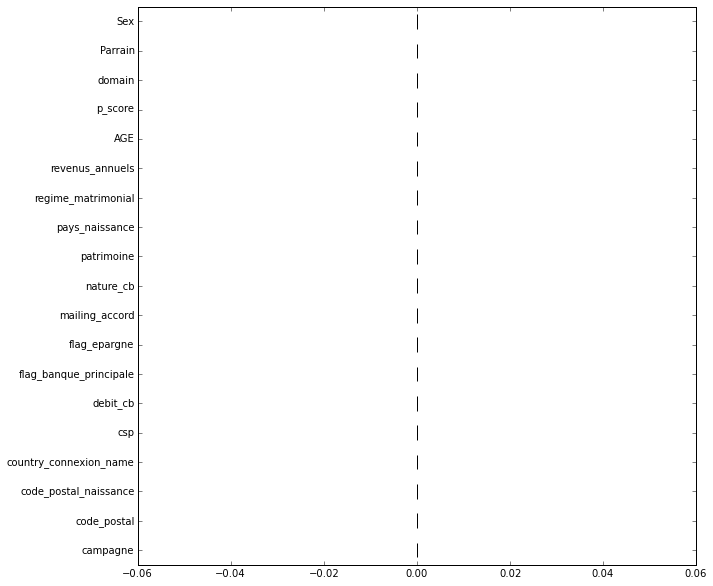

In [434]:
%matplotlib inline  
X.isnull().sum().plot(kind="barh",figsize=(10,10))

In [435]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, jaccard_similarity_score, precision_score, f1_score, recall_score

In [436]:
X0_train,X0_test,y0_train,y0_test=train_test_split(X,y,random_state=42)

In [437]:
# RF
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=100,criterion='entropy')
clf_RF = clf_RF.fit(X0_train, y0_train)
'''
scores_RF = cross_val_score(clf_RF, X0_train, y0_train)
y_pred = clf_RF.predict(X0_test)

print 'cross validation score : '+ str(scores_RF.mean())
'''
y_pred = clf_RF.predict(X0_test)

print 'accuracy score : '+ str(accuracy_score(y0_test, y_pred))
print 'recall score : '+ str(recall_score(y0_test, y_pred))
print 'Precision : '+ str(precision_score(y0_test, y_pred))

accuracy score : 0.782104391052
recall score : 0.0750332005312
Precision : 0.379194630872


In [355]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=300)
clf = clf.fit(X0_train, y0_train)
#scores = cross_val_score(clf, X0_train, y0_train)

y_pred = clf.predict(X0_test)

#print 'cross validation score : '+ str(scores.mean())
print 'accuracy score : '+ str(accuracy_score(y0_test, y_pred))
print 'recall score : '+ str(recall_score(y0_test, y_pred))
print 'Precision : '+ str(precision_score(y0_test, y_pred))

accuracy score : 0.793841480254
recall score : 0.0715705765408
Precision : 0.54


In [360]:
# Gradient boost
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100,random_state=10).fit(X0_train, y0_train)
clf = clf.fit(X0_train, y0_train)
#scores = cross_val_score(clf, X0_train, y0_train)

y_pred = clf.predict(X0_test)

#print 'cross validation score : '+ str(scores.mean())
print 'accuracy score : '+ str(accuracy_score(y0_test, y_pred))
print 'recall score : '+ str(recall_score(y0_test, y_pred))
print 'Precision : '+ str(precision_score(y0_test, y_pred))

accuracy score : 0.791770229218
recall score : 0.0410868124586
Precision : 0.50406504065


In [357]:
# Support vector machine
from sklearn import svm
clf = svm.SVC()
clf.fit(X0_train, y0_train)
#scores = cross_val_score(clf, X0_train, y0_train)

y_pred = clf.predict(X0_test)

#print 'cross validation score : '+ str(scores.mean())
print 'accuracy score : '+ str(accuracy_score(y0_test, y_pred))
print 'recall score : '+ str(recall_score(y0_test, y_pred))
print 'Precision : '+ str(precision_score(y0_test, y_pred))

accuracy score : 0.789975144988
recall score : 0.00198807157058
Precision : 0.166666666667


In [358]:
# KNN 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X0_train, y0_train)
#scores = cross_val_score(neigh, X0_train, y0_train)

y_pred = neigh.predict(X0_test)

#print 'cross validation score : '+ str(scores.mean())
print 'accuracy score : '+ str(accuracy_score(y0_test, y_pred))
print 'recall score : '+ str(recall_score(y0_test, y_pred))
print 'Precision : '+ str(precision_score(y0_test, y_pred))

accuracy score : 0.790803645402
recall score : 0.00132538104705
Precision : 0.2


In [359]:
# Naive bayes
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X0_train, y0_train)
#scores = cross_val_score(clf, X0_train, y0_train)

y_pred = clf.predict(X0_test)

#print 'cross validation score : '+ str(scores.mean())
print 'accuracy score : '+ str(accuracy_score(y0_test, y_pred))
print 'recall score : '+ str(recall_score(y0_test, y_pred))
print 'Precision : '+ str(precision_score(y0_test, y_pred))

accuracy score : 0.782518641259
recall score : 0.0616302186879
Precision : 0.369047619048


In [448]:
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000.0

# Training RBM-Logistic Pipeline
classifier.fit(X0_train, y0_train)

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)
logistic_classifier.fit(X0_train, y0_train)





[BernoulliRBM] Iteration 1, pseudo-likelihood = -279979237.98, time = 0.44s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -560002430.04, time = 0.64s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -840025623.07, time = 0.63s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -1120048816.95, time = 0.58s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1400072008.11, time = 0.62s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -1680095199.00, time = 0.60s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -1960118395.27, time = 0.57s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2240141584.19, time = 0.57s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2520164774.19, time = 0.67s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2800187969.63, time = 0.59s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -3080211162.40, time = 0.56s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -3360234354.63, time = 0.67s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -3640257548.33, time = 0.58

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [450]:
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        y0_test,
        classifier.predict(X0_test))))

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        y0_test,
        logistic_classifier.predict(X0_test))))

Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.79      1.00      0.88      5736
          1       0.00      0.00      0.00      1506

avg / total       0.63      0.79      0.70      7242


Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.79      1.00      0.88      5736
          1       0.25      0.00      0.00      1506

avg / total       0.68      0.79      0.70      7242




/opt/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [438]:
# MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5, 30), random_state=1)
clf.fit(X0_train, y0_train)
y_pred = clf.predict(X0_test)
print 'accuracy score : '+ str(accuracy_score(y0_test, y_pred))
print 'recall score : '+ str(recall_score(y0_test, y_pred))
precision_score(y0_test, y_pred)

ImportError: cannot import name MLPClassifier